# Note :

(a). We can't apply Naive Bayes on negative values so we will use only Bag of Words(Bow) and TFIDF for this assignment .

(b). Range for alpha is taken from 10^-3 to 10^3

# Objective : Apply Naive Bayes on Amazon Fine Food Reviews .

In [2]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# Loading Data

In [3]:
# using the SQLite Table to read data.
con1 = sqlite3.connect('database.sqlite')

# Eliminating neutral reviews i.e. those reviews with Score = 3
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con1)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def polarity(x):
    if x < 3:
        return 'negative'
    return 'positive'

# Applying polarity function on Score column of filtered_data
filtered_data['Score'] = filtered_data['Score'].map(polarity)

print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Cleaning: Deduplication

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(364173, 10)


69.25890143662969

In [5]:
# Removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

print(final.shape)
final[30:50]

(364171, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
138676,150493,0006641040,AMX0PJKV4PPNJ,"E. R. Bird ""Ramseelbird""",71,72,positive,1096416000,Read it once. Read it twice. Reading Chicken S...,"These days, when a person says, ""chicken soup""..."
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,positive,1009324800,It Was a favorite!,This was a favorite book of mine when I was a ...
138681,150499,0006641040,A3E7R866M94L0C,"L. Barker ""simienwolf""",2,2,positive,1065830400,Can't explain why,This book has been a favorite of mine since I ...
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...
284375,308077,2841233731,A3QD68O22M2XHQ,LABRNTH,0,0,positive,1345852800,Great recipe book for my babycook,This book is easy to read and the ingredients ...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...


OBSERVATION :- Here books with ProductId - 0006641040 and 2841233731 are also there so we have to remove all these rows with these ProductIds from the data

In [6]:
final = final[final['ProductId'] != '2841233731']
final = final[final['ProductId'] != '0006641040']
final.shape

(364136, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

In [7]:
#set of stopwords in English
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [8]:
#Code for removing HTML tags , punctuations . Code for removing stopwords . Code for checking if word is not alphanumeric and
# also greater than 2 . Code for stemmimg and also to convert them to lowercase letters 
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [9]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
157850,171161,7310172001,AFXMWPNS1BLU4,H. Sandler,0,0,positive,1229385600,Excellent treats,I have been feeding my greyhounds these treats...,feed greyhound treat year hound littl finicki ...
157849,171160,7310172001,A74C7IARQEM1R,stucker,0,0,positive,1230076800,Sophie's Treats,This is one product that my welsh terrier can ...,one product welsh terrier eat sophi food alerg...


TIME BASED SPLITTING OF SAMPLE DATASET

In [10]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# (1). Bag of Words (BoW)

In [11]:
#BoW
count_vect = CountVectorizer(min_df = 10) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (254895, 12739)
the number of unique words : 12739


# (1.a) Bernoulli Naive Bayes Classifier

# 10 Fold Cross Validation 

In [12]:
# Importing libraries
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

# Creating alpha values in the range from 10^-3 to 10^3
neighbors = []
i = 0.001
while(i<=1000):
    neighbors.append(np.round(i,3))
    i *= 3

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    bn = BernoulliNB(alpha = k)
    scores = cross_val_score(bn, X_train_vec, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())  
    
# determining best value of alpha
optimal_alpha = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)    


The optimal value of alpha is 0.001.


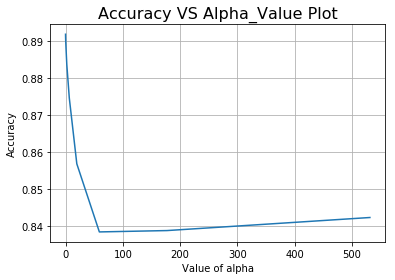



Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

Accuracy for each alpha value is :
  [0.89194 0.89192 0.89176 0.89152 0.89114 0.89032 0.88849 0.88376 0.87466
 0.85684 0.83839 0.83876 0.8423 ]


In [13]:
# plot accuracy vs alpha 
plt.plot(neighbors, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha_Value Plot',size=16)
plt.grid()
plt.show()

print("\n\nAlpha values :\n",neighbors)
print("\nAccuracy for each alpha value is :\n ", np.round(cv_scores,5))

In [14]:
# ============================== Bernoulli Naive Bayes with alpha = optimal_alpha ==============================================
# instantiate learning model alpha = optimal_alpha
bn_optimal = BernoulliNB(alpha = optimal_alpha)

# fitting the model
bn_optimal.fit(X_train_vec, Y_train)

# predict the response
predictions = bn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Bernoulli naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_bernoulli_alpha = optimal_alpha
bow_bernoulli_train_acc = max(cv_scores)*100
bow_bernoulli_test_acc = acc


The Test Accuracy of the Bernoulli naive Bayes classifier for alpha = 0.001 is 89.365714%


# Top 20 Important Features Per Class Are :-

In [15]:
bn_optimal.classes_

array(['negative', 'positive'], dtype='<U8')

From above we can see that first_class is 'negative' and second_class is 'positive'

In [16]:
# Now we can find log probabilities of different features for both the classes
class_features = bn_optimal.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))    

Top 20 Important Features and their log probabilities For Negative Class :


tast	 -->	-0.987744  
like	 -->	-1.001583  
product	 -->	-1.177819  
one	 -->	-1.355610  
would	 -->	-1.417847  
tri	 -->	-1.467070  
flavor	 -->	-1.548114  
good	 -->	-1.552114  
buy	 -->	-1.602521  
get	 -->	-1.655996  
use	 -->	-1.681294  
dont	 -->	-1.744126  
even	 -->	-1.821458  
order	 -->	-1.834662  
make	 -->	-1.971348  
much	 -->	-1.973322  
time	 -->	-1.995297  
realli	 -->	-2.026252  
look	 -->	-2.054878  
amazon	 -->	-2.066640  


Top 20 Important Features and their log probabilities For Positive Class :


like	 -->	-1.175476  
tast	 -->	-1.204468  
love	 -->	-1.260625  
good	 -->	-1.265811  
great	 -->	-1.295596  
flavor	 -->	-1.423290  
one	 -->	-1.467773  
use	 -->	-1.479067  
tri	 -->	-1.520718  
product	 -->	-1.537382  
make	 -->	-1.657849  
get	 -->	-1.684409  
buy	 -->	-1.893541  
time	 -->	-1.902954  
would	 -->	-1.928464  
realli	 -->	-1.967278  
best	 -->	-1.989593  
amazon	 -->	-1.99700

# Now Evaluate : Accuracy , F1-Score , Precision , Recall , Confusion_Matrix , TPR , FPR , TNR , FNR

In [17]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Bernoulli naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Bernoulli naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Bernoulli naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Bernoulli naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))



The Test Accuracy of the Bernoulli naive Bayes classifier for alpha = 0.001 is 89.365714%

The Test Precision of the Bernoulli naive Bayes classifier for alpha = 0.001 is 0.937157

The Test Recall of the Bernoulli naive Bayes classifier for alpha = 0.001 is 0.936801

The Test F1-Score of the Bernoulli naive Bayes classifier for alpha = 0.001 is 0.936979


In [18]:
# Evaluate TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(Y_test, predictions).ravel()

# Evaluate TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR of the Bernoulli naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TPR))

# Evaluate FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR of the Bernoulli naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FPR))

# Evaluate TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR of the Bernoulli naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TNR))

# Evaluate FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR of the Bernoulli naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FNR))

TPR of the Bernoulli naive Bayes classifier for alpha = 0.001 is :  0.937157
FPR of the Bernoulli naive Bayes classifier for alpha = 0.001 is :  0.340881
TNR of the Bernoulli naive Bayes classifier for alpha = 0.001 is :  0.659119
FNR of the Bernoulli naive Bayes classifier for alpha = 0.001 is :  0.062843


 Seaborn Heatmap For Representation of Confusion Matrix :

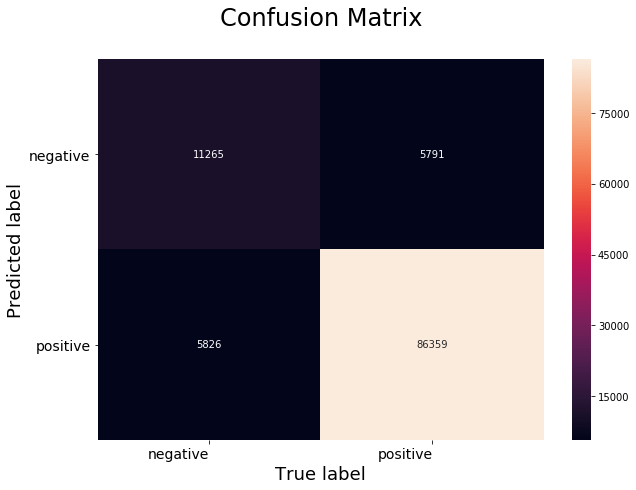

In [19]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (1.b) Multinomial Naive Bayes Classifier

# 10 Fold Cross Validation

In [20]:
from sklearn.naive_bayes import MultinomialNB

# Creating alpha values in the range from 10^-3 to 10^3
neighbors = []
i = 0.001
while(i<=1000):
    neighbors.append(np.round(i,3))
    i *= 3

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    bn = MultinomialNB(alpha = k)
    scores = cross_val_score(bn, X_train_vec, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())  
    
# determining best value of alpha
optimal_alpha = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha) 


The optimal value of alpha is 0.009.


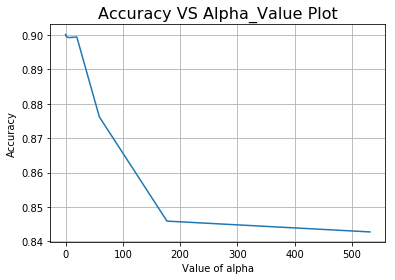



Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

Accuracy for each alpha value is :
  [0.90019 0.90023 0.90025 0.90025 0.90023 0.90015 0.89978 0.89944 0.89929
 0.89945 0.87621 0.84591 0.84276]


In [21]:
# plot accuracy vs alpha 
plt.plot(neighbors, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha_Value Plot',size=16)
plt.grid()
plt.show()

print("\n\nAlpha values :\n",neighbors)
print("\nAccuracy for each alpha value is :\n ", np.round(cv_scores,5))

In [22]:
# ============================== Multinomial Naive Bayes with alpha = optimal_alpha ============================================
# instantiate learning model alpha = optimal_alpha
bn_optimal = MultinomialNB(alpha = optimal_alpha)

# fitting the model
bn_optimal.fit(X_train_vec, Y_train)

# predict the response
predictions = bn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_multinomial_alpha = optimal_alpha
bow_multinomial_train_acc = max(cv_scores)*100
bow_multinomial_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.009 is 90.191412%


# Top 20 Important Features Per Class Are :-

In [23]:
bn_optimal.classes_

array(['negative', 'positive'], dtype='<U8')

From above we can see that first_class is 'negative' and second_class is 'positive'

In [24]:
# Now we can find log probabilities of different features for both the classes
class_features = bn_optimal.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))  

Top 20 Important Features and their log probabilities For Negative Class :


tast	 -->	-4.211208  
like	 -->	-4.275870  
product	 -->	-4.411933  
one	 -->	-4.729366  
flavor	 -->	-4.778510  
would	 -->	-4.863789  
tri	 -->	-4.878241  
use	 -->	-5.026657  
coffe	 -->	-5.039993  
good	 -->	-5.043213  
get	 -->	-5.131303  
buy	 -->	-5.139937  
order	 -->	-5.189192  
food	 -->	-5.201784  
tea	 -->	-5.274021  
dont	 -->	-5.275934  
even	 -->	-5.342246  
box	 -->	-5.362271  
amazon	 -->	-5.434784  
bag	 -->	-5.466863  


Top 20 Important Features and their log probabilities For Positive Class :


like	 -->	-4.413711  
tast	 -->	-4.491244  
good	 -->	-4.623394  
flavor	 -->	-4.654844  
love	 -->	-4.675000  
great	 -->	-4.707180  
use	 -->	-4.708460  
one	 -->	-4.778937  
product	 -->	-4.837269  
tri	 -->	-4.885283  
tea	 -->	-4.918532  
coffe	 -->	-4.973927  
make	 -->	-5.031791  
get	 -->	-5.068710  
food	 -->	-5.178502  
would	 -->	-5.333505  
time	 -->	-5.337991  
buy	 -->	-5.359727  
real

# Now Evaluate : Accuracy , F1-Score , Precision , Recall , Confusion_Matrix , TPR , FPR , TNR , FNR

In [25]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))



The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.009 is 90.191412%

The Test Precision of the Multinomial naive Bayes classifier for alpha = 0.009 is 0.945981

The Test Recall of the Multinomial naive Bayes classifier for alpha = 0.009 is 0.937289

The Test F1-Score of the Multinomial naive Bayes classifier for alpha = 0.009 is 0.941615


In [26]:
# Evaluate TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(Y_test, predictions).ravel()

# Evaluate TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TPR))

# Evaluate FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FPR))

# Evaluate TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TNR))

# Evaluate FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FNR))

TPR of the Multinomial naive Bayes classifier for alpha = 0.009 is :  0.945981
FPR of the Multinomial naive Bayes classifier for alpha = 0.009 is :  0.322907
TNR of the Multinomial naive Bayes classifier for alpha = 0.009 is :  0.677093
FNR of the Multinomial naive Bayes classifier for alpha = 0.009 is :  0.054019


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

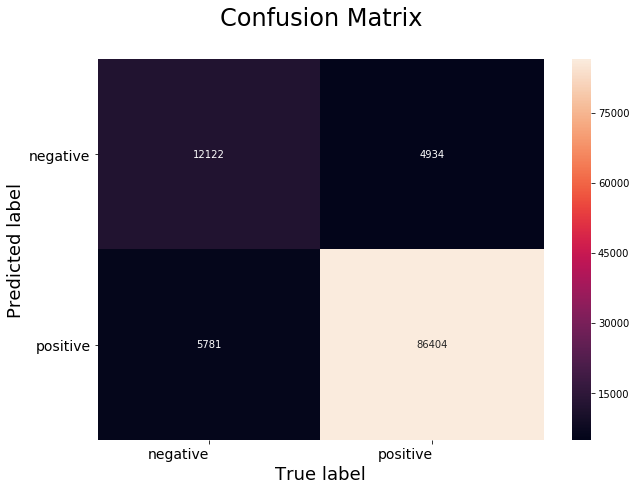

In [27]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (2). TF-IDF

In [28]:
tf_idf_vect = TfidfVectorizer(min_df=10)
X_train_vec = tf_idf_vect.fit_transform(X_train)
X_test_vec = tf_idf_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text TFIDF vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (254895, 12739)
the number of unique words : 12739


# (2.a) Bernoulli Naive Bayes Classifier

# 10 Fold Cross Validation

In [29]:
# Creating alpha values in the range from 10^-3 to 10^3
neighbors = []
i = 0.001
while(i<=1000):
    neighbors.append(np.round(i,3))
    i *= 3

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    bn = BernoulliNB(alpha = k)
    scores = cross_val_score(bn, X_train_vec, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())  
    
# determining best value of alpha
optimal_alpha = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.001.


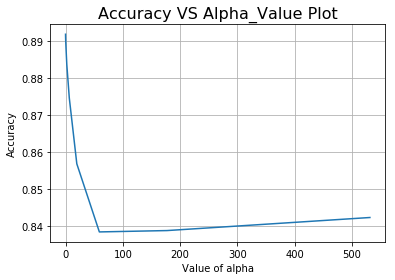



Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

Accuracy for each alpha value is :
  [0.89194 0.89192 0.89176 0.89152 0.89114 0.89032 0.88849 0.88376 0.87466
 0.85684 0.83839 0.83876 0.8423 ]


In [30]:
# plot accuracy vs alpha 
plt.plot(neighbors, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha_Value Plot',size=16)
plt.grid()
plt.show()

print("\n\nAlpha values :\n",neighbors)
print("\nAccuracy for each alpha value is :\n ", np.round(cv_scores,5))

In [31]:
# ============================== Bernoulli Naive Bayes with alpha = optimal_alpha ==============================================
# instantiate learning model alpha = optimal_alpha
bn_optimal = BernoulliNB(alpha = optimal_alpha)

# fitting the model
bn_optimal.fit(X_train_vec, Y_train)

# predict the response
predictions = bn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Bernoulli naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_bernoulli_alpha = optimal_alpha
tfidf_bernoulli_train_acc = max(cv_scores)*100
tfidf_bernoulli_test_acc = acc


The Test Accuracy of the Bernoulli naive Bayes classifier for alpha = 0.001 is 89.365714%


# Top 20 Important Features Per Class Are :-

In [32]:
bn_optimal.classes_

array(['negative', 'positive'], dtype='<U8')

From above we can see that first_class is 'negative' and second_class is 'positive'

In [33]:
# Now we can find log probabilities of different features for both the classes
class_features = bn_optimal.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = tf_idf_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))    

Top 20 Important Features and their log probabilities For Negative Class :


tast	 -->	-0.987744  
like	 -->	-1.001583  
product	 -->	-1.177819  
one	 -->	-1.355610  
would	 -->	-1.417847  
tri	 -->	-1.467070  
flavor	 -->	-1.548114  
good	 -->	-1.552114  
buy	 -->	-1.602521  
get	 -->	-1.655996  
use	 -->	-1.681294  
dont	 -->	-1.744126  
even	 -->	-1.821458  
order	 -->	-1.834662  
make	 -->	-1.971348  
much	 -->	-1.973322  
time	 -->	-1.995297  
realli	 -->	-2.026252  
look	 -->	-2.054878  
amazon	 -->	-2.066640  


Top 20 Important Features and their log probabilities For Positive Class :


like	 -->	-1.175476  
tast	 -->	-1.204468  
love	 -->	-1.260625  
good	 -->	-1.265811  
great	 -->	-1.295596  
flavor	 -->	-1.423290  
one	 -->	-1.467773  
use	 -->	-1.479067  
tri	 -->	-1.520718  
product	 -->	-1.537382  
make	 -->	-1.657849  
get	 -->	-1.684409  
buy	 -->	-1.893541  
time	 -->	-1.902954  
would	 -->	-1.928464  
realli	 -->	-1.967278  
best	 -->	-1.989593  
amazon	 -->	-1.99700

# Now Evaluate : Accuracy , F1-Score , Precision , Recall , Confusion_Matrix , TPR , FPR , TNR , FNR

In [34]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Bernoulli naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Bernoulli naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Bernoulli naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Bernoulli naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))



The Test Accuracy of the Bernoulli naive Bayes classifier for alpha = 0.001 is 89.365714%

The Test Precision of the Bernoulli naive Bayes classifier for alpha = 0.001 is 0.937157

The Test Recall of the Bernoulli naive Bayes classifier for alpha = 0.001 is 0.936801

The Test F1-Score of the Bernoulli naive Bayes classifier for alpha = 0.001 is 0.936979


In [35]:
# Evaluate TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(Y_test, predictions).ravel()

# Evaluate TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR of the Bernoulli naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TPR))

# Evaluate FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR of the Bernoulli naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FPR))

# Evaluate TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR of the Bernoulli naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TNR))

# Evaluate FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR of the Bernoulli naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FNR))

TPR of the Bernoulli naive Bayes classifier for alpha = 0.001 is :  0.937157
FPR of the Bernoulli naive Bayes classifier for alpha = 0.001 is :  0.340881
TNR of the Bernoulli naive Bayes classifier for alpha = 0.001 is :  0.659119
FNR of the Bernoulli naive Bayes classifier for alpha = 0.001 is :  0.062843


SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

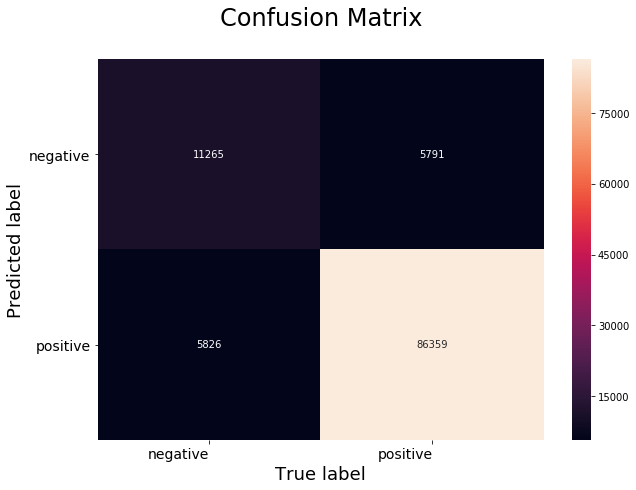

In [36]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# (2.b) Multinomial Naive Bayes Classifier

# 10 Fold Cross Validation

In [37]:
# Creating alpha values in the range from 10^-3 to 10^3
neighbors = []
i = 0.001
while(i<=1000):
    neighbors.append(np.round(i,3))
    i *= 3

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    bn = MultinomialNB(alpha = k)
    scores = cross_val_score(bn, X_train_vec, Y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())  
    
# determining best value of alpha
optimal_alpha = neighbors[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of alpha is %.3f.' % optimal_alpha)


The optimal value of alpha is 0.027.


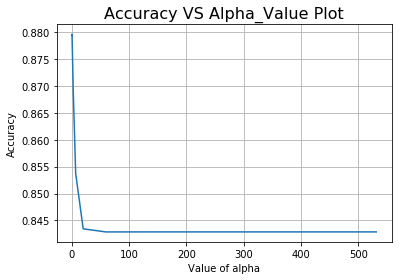



Alpha values :
 [0.001, 0.003, 0.009, 0.027, 0.081, 0.243, 0.729, 2.187, 6.561, 19.683, 59.049, 177.147, 531.441]

Accuracy for each alpha value is :
  [0.87945 0.87948 0.87953 0.87961 0.87953 0.87914 0.87692 0.86959 0.85375
 0.84344 0.84286 0.84287 0.84287]


In [38]:
# plot accuracy vs alpha 
plt.plot(neighbors, cv_scores)
plt.xlabel('Value of alpha',size=10)
plt.ylabel('Accuracy',size=10)
plt.title('Accuracy VS Alpha_Value Plot',size=16)
plt.grid()
plt.show()

print("\n\nAlpha values :\n",neighbors)
print("\nAccuracy for each alpha value is :\n ", np.round(cv_scores,5))

In [39]:
# ============================== Multinomial Naive Bayes with alpha = optimal_alpha ============================================
# instantiate learning model alpha = optimal_alpha
bn_optimal = MultinomialNB(alpha = optimal_alpha)

# fitting the model
bn_optimal.fit(X_train_vec, Y_train)

# predict the response
predictions = bn_optimal.predict(X_test_vec)

# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_multinomial_alpha = optimal_alpha
tfidf_multinomial_train_acc = max(cv_scores)*100
tfidf_multinomial_test_acc = acc


The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.027 is 88.040205%


# Top 20 Important Features Per Class Are :-

In [40]:
bn_optimal.classes_

array(['negative', 'positive'], dtype='<U8')

From above we can see that first_class is 'negative' and second_class is 'positive'

In [41]:
# Now we can find log probabilities of different features for both the classes
class_features = bn_optimal.feature_log_prob_

#  row_0 is for 'negative' class and row_1 is for 'positive' class
negative_features = class_features[0]
positive_features = class_features[1]

# Getting all feature names
feature_names = tf_idf_vect.get_feature_names()

# Sorting 'negative_features' and 'positive_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]
sorted_positive_features = np.argsort(positive_features)[::-1]

print("Top 20 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n\nTop 20 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:20]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))   

Top 20 Important Features and their log probabilities For Negative Class :


tast	 -->	-4.816971  
like	 -->	-4.964158  
product	 -->	-4.980686  
would	 -->	-5.306868  
coffe	 -->	-5.324640  
flavor	 -->	-5.334298  
one	 -->	-5.353519  
tri	 -->	-5.459168  
buy	 -->	-5.465362  
order	 -->	-5.472430  
box	 -->	-5.577193  
disappoint	 -->	-5.606259  
tea	 -->	-5.610177  
good	 -->	-5.636388  
dont	 -->	-5.641933  
get	 -->	-5.653298  
use	 -->	-5.698215  
even	 -->	-5.730978  
food	 -->	-5.752900  
bag	 -->	-5.762344  


Top 20 Important Features and their log probabilities For Positive Class :


great	 -->	-5.040164  
love	 -->	-5.048959  
tast	 -->	-5.111444  
good	 -->	-5.112518  
like	 -->	-5.131742  
tea	 -->	-5.185184  
flavor	 -->	-5.189635  
coffe	 -->	-5.197630  
product	 -->	-5.279732  
use	 -->	-5.297337  
one	 -->	-5.393326  
tri	 -->	-5.446777  
make	 -->	-5.534496  
get	 -->	-5.578981  
price	 -->	-5.622630  
buy	 -->	-5.636730  
best	 -->	-5.647731  
food	 -->	-5.660888  


# Now Evaluate : Accuracy , F1-Score , Precision , Recall , Confusion_Matrix , TPR , FPR , TNR , FNR

In [42]:
# evaluate accuracy
acc = accuracy_score(Y_test, predictions) * 100
print('\nThe Test Accuracy of the Multinomial naive Bayes classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# evaluate precision
acc = precision_score(Y_test, predictions, pos_label = 'positive') 
print('\nThe Test Precision of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate recall
acc = recall_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test Recall of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))

# evaluate f1-score
acc = f1_score(Y_test, predictions, pos_label = 'positive')
print('\nThe Test F1-Score of the Multinomial naive Bayes classifier for alpha = %.3f is %f' % (optimal_alpha, acc))



The Test Accuracy of the Multinomial naive Bayes classifier for alpha = 0.027 is 88.040205%

The Test Precision of the Multinomial naive Bayes classifier for alpha = 0.027 is 0.879735

The Test Recall of the Multinomial naive Bayes classifier for alpha = 0.027 is 0.994186

The Test F1-Score of the Multinomial naive Bayes classifier for alpha = 0.027 is 0.933465


In [43]:
# Evaluate TPR , FPR , TNR , FNR
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(Y_test, predictions).ravel()

# Evaluate TPR (TPR = TP/(FN+TP))
TPR = TruePos/(FalseNeg + TruePos)
print("TPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TPR))

# Evaluate FPR (FPR = FP/(TN+FP))
FPR = FalsePos/(TrueNeg + FalsePos)
print("FPR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FPR))

# Evaluate TNR (TNR = TN/(TN+FP))
TNR = TrueNeg/(TrueNeg + FalsePos)
print("TNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,TNR))

# Evaluate FNR (FNR = TN/(FN+TP))
FNR = FalseNeg/(FalseNeg + TruePos)
print("FNR of the Multinomial naive Bayes classifier for alpha = %.3f is :  %f" % (optimal_alpha,FNR))

TPR of the Multinomial naive Bayes classifier for alpha = 0.027 is :  0.879735
FPR of the Multinomial naive Bayes classifier for alpha = 0.027 is :  0.105866
TNR of the Multinomial naive Bayes classifier for alpha = 0.027 is :  0.894134
FNR of the Multinomial naive Bayes classifier for alpha = 0.027 is :  0.120265


 SEABORN HEATMAP FOR REPRESENTATION OF CONFUSION MATRIX :

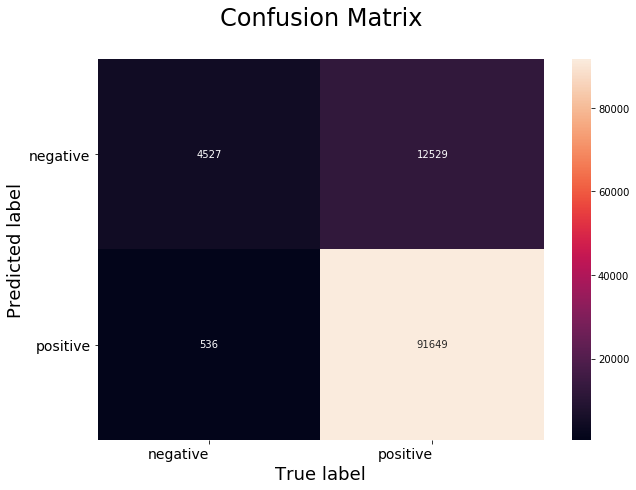

In [44]:
# Code for drawing seaborn heatmaps
class_names = ['negative','positive']
df_heatmap = pd.DataFrame(confusion_matrix(Y_test, predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('Predicted label',size=18)
plt.xlabel('True label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# CONCLUSION :

# (a). Procedure followed :

STEP 1 :- Text Preprocessing

STEP 2:- Time-based splitting of whole dataset into train_data and test_data

STEP 3:- Training the vectorizer on train_data and later applying same vectorizer on both train_data and test_data to transform them into vectors

STEP 4:- Using Bernoulli Naive Bayes as an estimator in 10-Fold Cross-Validation in order to find optimal value of alpha .

STEP 5:- Draw "Accuracy VS Alpha_value" plot

STEP 6:- Once , we get optimal value of alpha then train BernoulliNB again with this optimal alpha and make predictions on test_data

STEP 7:- Find important features per class

STEP 8 :- Evaluate : Accuracy , F1-Score , Precision , Recall , TPR , FPR , TNR , FNR

STEP 9:- Draw Seaborn Heatmap for Confusion Matrix .

STEP 10 :- Repeat from STEP 4 to STEP 9 using Multinomial Naive Bayes as an estimator

Repeat from STEP 3 to STEP 10 for each of these two vectorizers : Bag Of Words(BoW), TFIDF

# (b). Table (Model Performances with their hyperparameters :

In [46]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

names = ["BernoulliNB for BoW", "MultinomialNB for BoW", "BernoulliNB for TFIDF", "MultinomialNB for TFIDF"]

optimal_alpha = [bow_bernoulli_alpha, bow_multinomial_alpha, tfidf_bernoulli_alpha, tfidf_multinomial_alpha]

train_acc = [bow_bernoulli_train_acc, bow_multinomial_train_acc, tfidf_bernoulli_train_acc, tfidf_multinomial_train_acc]

test_acc = [bow_bernoulli_test_acc, bow_multinomial_test_acc, tfidf_bernoulli_test_acc, tfidf_multinomial_test_acc]

numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best Alpha",optimal_alpha)
ptable.add_column("Training Accuracy",train_acc)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+-------------------------+------------+-------------------+-------------------+
| S.NO. |          MODEL          | Best Alpha | Training Accuracy |   Test Accuracy   |
+-------+-------------------------+------------+-------------------+-------------------+
|   1   |   BernoulliNB for BoW   |   0.001    |  89.1943733660152 | 89.36571433802327 |
|   2   |  MultinomialNB for BoW  |   0.009    |  90.0253049504307 | 90.19141164947226 |
|   3   |  BernoulliNB for TFIDF  |   0.001    |  89.1943733660152 | 89.36571433802327 |
|   4   | MultinomialNB for TFIDF |   0.027    | 87.96092412822742 | 88.04020468505415 |
+-------+-------------------------+------------+-------------------+-------------------+
